# Exercises on deep learning - TP8 AAA
##### Duarte Balata (46304) Miguel Oliveira (55772)


We start the notebook by following the steps on the presented tutorial, then we implement the model from the tutorial with the suggested modifications. At the end of the notebook we display the combined results for all trials and end up with a final conclusion on the effects of the parameter changes on our model performance.

## Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


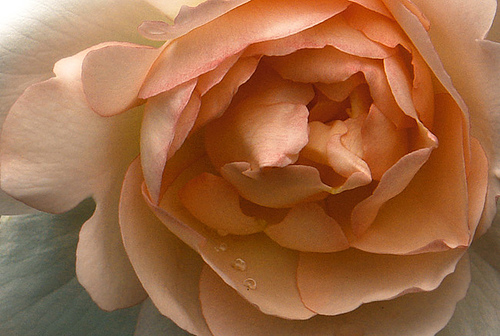

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(roses[5])

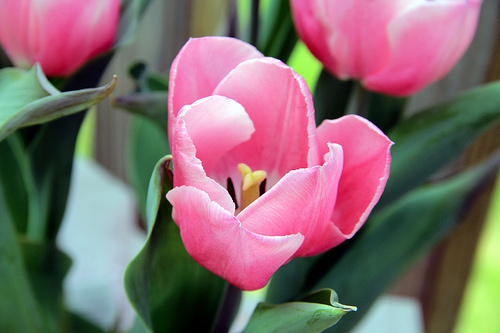

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(tulips[5])

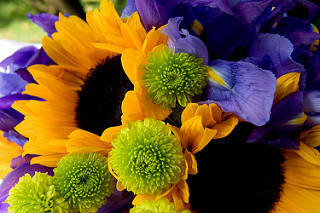

In [6]:
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(sunflowers[5])

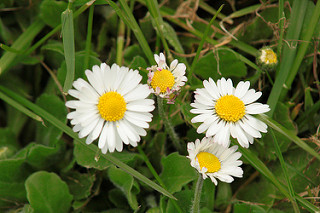

In [7]:
daisys = list(data_dir.glob('daisy/*'))
PIL.Image.open(daisys[9])

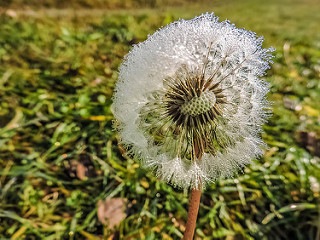

In [8]:
dandelions = list(data_dir.glob('dandelion/*'))
PIL.Image.open(dandelions[5])

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


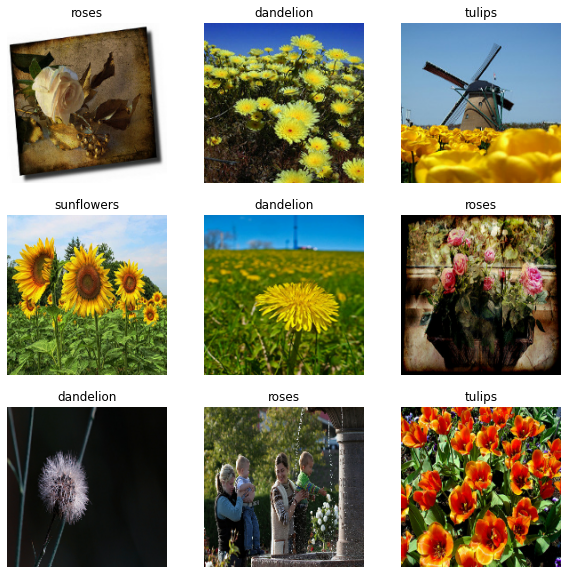

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9524634


In [18]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 30s 318ms/step - loss: 1.6661 - accuracy: 0.2966 - val_loss: 1.2495 - val_accuracy: 0.5082
Epoch 2/10
92/92 [==============================] - 28s 308ms/step - loss: 1.1187 - accuracy: 0.5614 - val_loss: 1.0454 - val_accuracy: 0.5668
Epoch 3/10
92/92 [==============================] - 29s 312ms/step - loss: 0.9259 - accuracy: 0.6399 - val_loss: 0.9700 - val_accuracy: 0.6131
Epoch 4/10
92/92 [==============================] - 30s 328ms/step - loss: 0.7260 - accuracy: 0.7386 - val_loss: 0.8831 - val_accuracy: 0.6608
Epoch 5/10
92/92 [==============================] - 29s 317ms/step - loss: 0.5163 - accuracy: 0.8200 - val_loss: 0.9777 - val_accuracy: 0.6349
Epoch 6/10
92/92 [==============================] - 30s 325ms/step - loss: 0.3341 - accuracy: 0.8884 - val_loss: 1.0266 - val_accuracy: 0.6703
Epoch 7/10
92/92 [==============================] - 27s 290ms/step - loss: 0.1632 - accuracy: 0.9552 - val_loss: 1.3037 - val_accuracy: 0.6349

In [22]:
def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

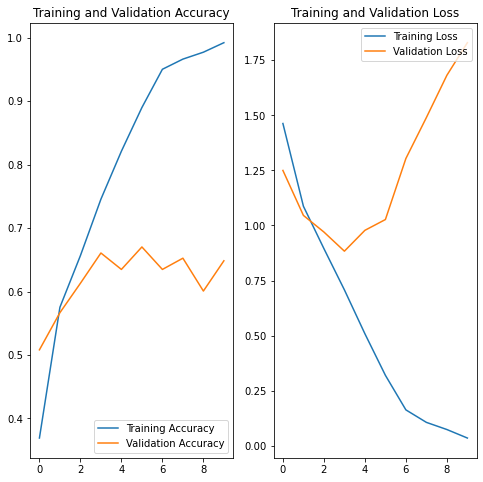

In [23]:
plot_acc_loss(history)

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

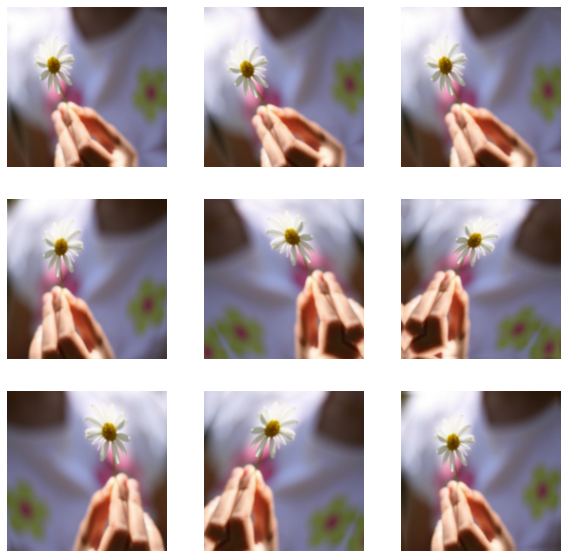

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Base Model

Here we try to predict our data labels by using the base model from the tutorial. We decided to change the number of epochs from 15 to 30, in order to make sure that we are able to capture the number of epoch needed until the model starts overfitting.

In [26]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [28]:
epochs = 30
history_base = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 32s 345ms/step - loss: 1.5356 - accuracy: 0.3234 - val_loss: 1.1998 - val_accuracy: 0.5150
Epoch 2/30
92/92 [==============================] - 30s 326ms/step - loss: 1.0946 - accuracy: 0.5608 - val_loss: 1.0659 - val_accuracy: 0.5477
Epoch 3/30
92/92 [==============================] - 33s 364ms/step - loss: 0.9846 - accuracy: 0.6083 - val_loss: 0.9632 - val_accuracy: 0.6213
Epoch 4/30
92/92 [==============================] - 31s 337ms/step - loss: 0.8841 - accuracy: 0.6618 - val_loss: 0.8638 - val_accuracy: 0.6594
Epoch 5/30
92/92 [==============================] - 31s 337ms/step - loss: 0.8336 - accuracy: 0.6741 - val_loss: 0.8218 - val_accuracy: 0.6717
Epoch 6/30
92/92 [==============================] - 31s 334ms/step - loss: 0.7685 - accuracy: 0.7026 - val_loss: 0.7806 - val_accuracy: 0.6948
Epoch 7/30
92/92 [==============================] - 32s 349ms/step - loss: 0.7064 - accuracy: 0.7246 - val_loss: 0.7678 - val_accuracy: 0.7071

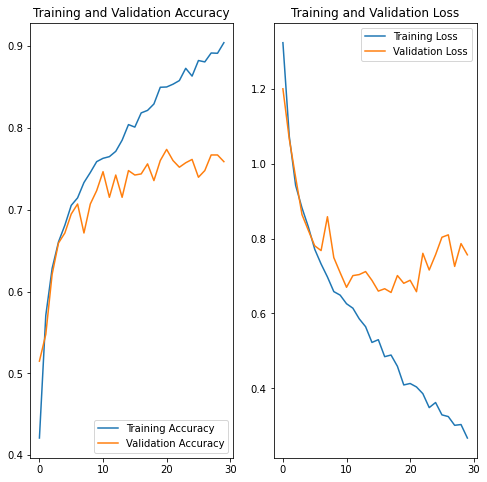

In [29]:
plot_acc_loss(history_base)

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 99.94 percent confidence.


Here, we add another random image from Google to further test our model.

In [31]:
daisy_url = "https://live.staticflickr.com/1884/43759928814_9d96a99652_b.jpg"
daisy_path = tf.keras.utils.get_file('daisy', origin=daisy_url)

img = keras.preprocessing.image.load_img(
    daisy_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))

)

This image most likely belongs to daisy with a 100.00 percent confidence.


# MeanSquaredLoss

We then change the loss function to Mean Squared Error, while maintaining the remaining network configuration and draw the learning curves, as shown in the tutorial.

In [32]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss= tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'],)

In [33]:
epochs = 30
history_msl = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 30s 323ms/step - loss: 5.6579 - accuracy: 0.1783 - val_loss: 1.5931 - val_accuracy: 0.1226
Epoch 2/30
92/92 [==============================] - 30s 322ms/step - loss: 1.5693 - accuracy: 0.1576 - val_loss: 1.4525 - val_accuracy: 0.1839
Epoch 3/30
92/92 [==============================] - 29s 318ms/step - loss: 1.4943 - accuracy: 0.1735 - val_loss: 1.3919 - val_accuracy: 0.1308
Epoch 4/30
92/92 [==============================] - 30s 328ms/step - loss: 1.3437 - accuracy: 0.1629 - val_loss: 1.8167 - val_accuracy: 0.1417
Epoch 5/30
92/92 [==============================] - 33s 361ms/step - loss: 1.2967 - accuracy: 0.1999 - val_loss: 1.2531 - val_accuracy: 0.2371
Epoch 6/30
92/92 [==============================] - 29s 319ms/step - loss: 1.1975 - accuracy: 0.1932 - val_loss: 1.2905 - val_accuracy: 0.1594
Epoch 7/30
92/92 [==============================] - 29s 320ms/step - loss: 1.1525 - accuracy: 0.2024 - val_loss: 1.2108 - val_accuracy: 0.2302

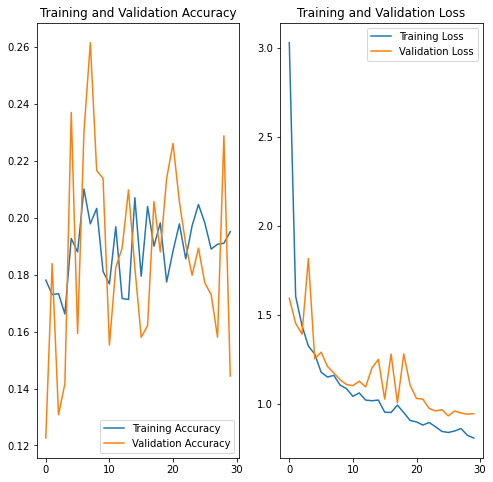

In [34]:
plot_acc_loss(history_msl)

# Dropout 40%

We then try the model with a dropout value of 40%, instead of 20%.

In [35]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
epochs = 30
history_drop40 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 30s 320ms/step - loss: 1.5765 - accuracy: 0.3035 - val_loss: 1.1249 - val_accuracy: 0.5409
Epoch 2/30
92/92 [==============================] - 29s 319ms/step - loss: 1.1345 - accuracy: 0.5242 - val_loss: 1.0556 - val_accuracy: 0.5749
Epoch 3/30
92/92 [==============================] - 30s 321ms/step - loss: 0.9851 - accuracy: 0.6156 - val_loss: 0.9690 - val_accuracy: 0.6281
Epoch 4/30
92/92 [==============================] - 30s 322ms/step - loss: 0.9222 - accuracy: 0.6455 - val_loss: 0.9822 - val_accuracy: 0.6117
Epoch 5/30
92/92 [==============================] - 30s 321ms/step - loss: 0.8859 - accuracy: 0.6658 - val_loss: 0.9094 - val_accuracy: 0.6390
Epoch 6/30
92/92 [==============================] - 30s 326ms/step - loss: 0.8156 - accuracy: 0.6832 - val_loss: 0.9189 - val_accuracy: 0.6267
Epoch 7/30
92/92 [==============================] - 29s 320ms/step - loss: 0.8023 - accuracy: 0.6885 - val_loss: 0.9496 - val_accuracy: 0.6322

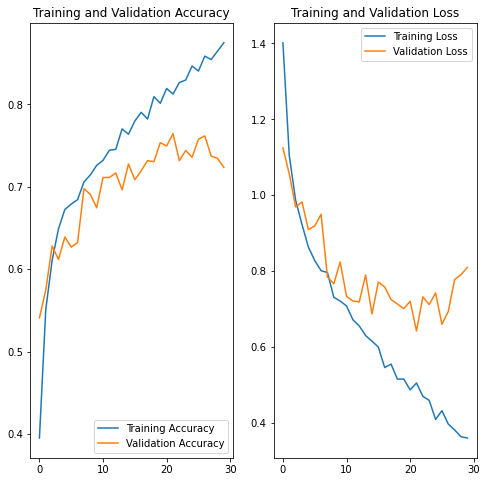

In [37]:
plot_acc_loss(history_drop40)

# Batch size 8

Then we change the batch size from 32 to 8.

In [38]:
batch_size = 8

train_ds_8 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [39]:
val_ds_8 = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [40]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
epochs = 30
history_batch8 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 30s 320ms/step - loss: 1.5208 - accuracy: 0.3504 - val_loss: 1.1170 - val_accuracy: 0.5163
Epoch 2/30
92/92 [==============================] - 30s 328ms/step - loss: 1.0620 - accuracy: 0.5883 - val_loss: 1.0125 - val_accuracy: 0.5981
Epoch 3/30
92/92 [==============================] - 32s 350ms/step - loss: 0.9322 - accuracy: 0.6385 - val_loss: 0.9190 - val_accuracy: 0.6376
Epoch 4/30
92/92 [==============================] - 31s 333ms/step - loss: 0.8556 - accuracy: 0.6701 - val_loss: 0.9318 - val_accuracy: 0.6431
Epoch 5/30
92/92 [==============================] - 29s 319ms/step - loss: 0.8158 - accuracy: 0.6901 - val_loss: 0.8485 - val_accuracy: 0.6635
Epoch 6/30
92/92 [==============================] - 30s 321ms/step - loss: 0.7907 - accuracy: 0.6954 - val_loss: 0.7867 - val_accuracy: 0.6880
Epoch 7/30
92/92 [==============================] - 30s 321ms/step - loss: 0.7239 - accuracy: 0.7207 - val_loss: 0.8292 - val_accuracy: 0.6662

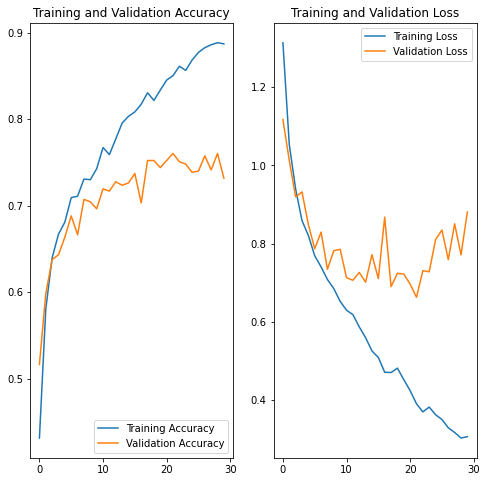

In [42]:
plot_acc_loss(history_batch8)

# Batch Normalization

Finally we perform batch normalization between each of the network layers.

In [43]:
from tensorflow.keras.layers import BatchNormalization

In [44]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
epochs = 30
history_norm = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
92/92 [==============================] - 45s 480ms/step - loss: 1.5669 - accuracy: 0.4651 - val_loss: 2.0152 - val_accuracy: 0.2398
Epoch 2/30
92/92 [==============================] - 44s 479ms/step - loss: 0.9336 - accuracy: 0.6365 - val_loss: 1.9413 - val_accuracy: 0.2616
Epoch 3/30
92/92 [==============================] - 44s 480ms/step - loss: 0.8051 - accuracy: 0.6882 - val_loss: 2.2160 - val_accuracy: 0.2834
Epoch 4/30
92/92 [==============================] - 44s 483ms/step - loss: 0.7911 - accuracy: 0.6971 - val_loss: 1.3351 - val_accuracy: 0.4782
Epoch 5/30
92/92 [==============================] - 44s 479ms/step - loss: 0.7115 - accuracy: 0.7334 - val_loss: 1.1020 - val_accuracy: 0.5586
Epoch 6/30
92/92 [==============================] - 44s 479ms/step - loss: 0.6608 - accuracy: 0.7454 - val_loss: 0.9539 - val_accuracy: 0.6308
Epoch 7/30
92/92 [==============================] - 44s 478ms/step - loss: 0.6459 - accuracy: 0.7602 - val_loss: 0.9536 - val_accuracy: 0.6403

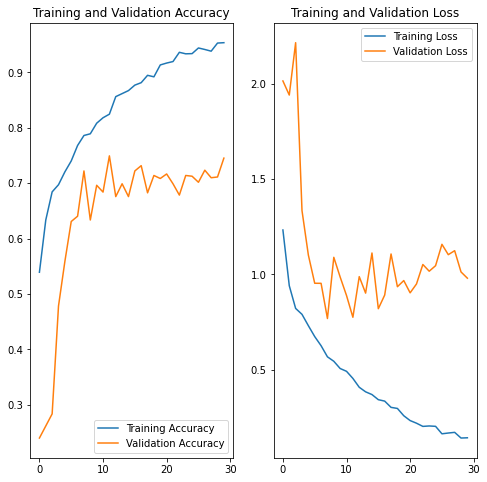

In [46]:
plot_acc_loss(history_norm)

# Final Results

We then present the combined plots of the learning curves for all the study cases. First we present the accuracy plots, then the loss.

## Accuracy

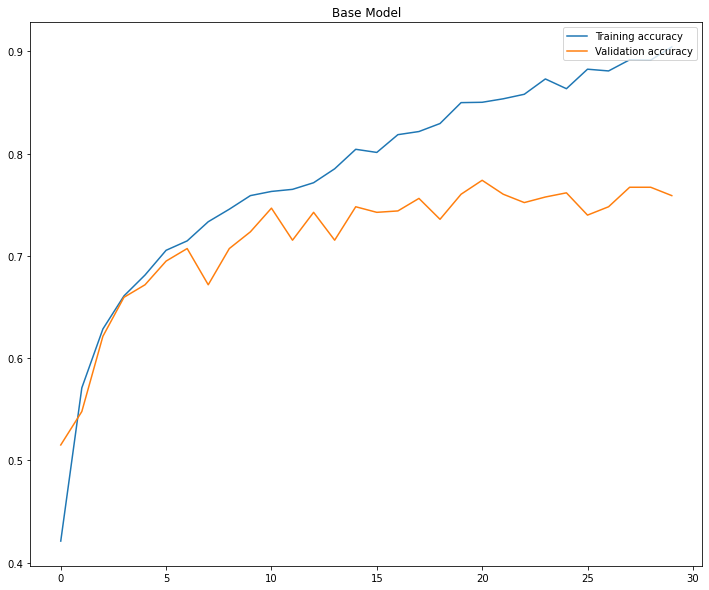

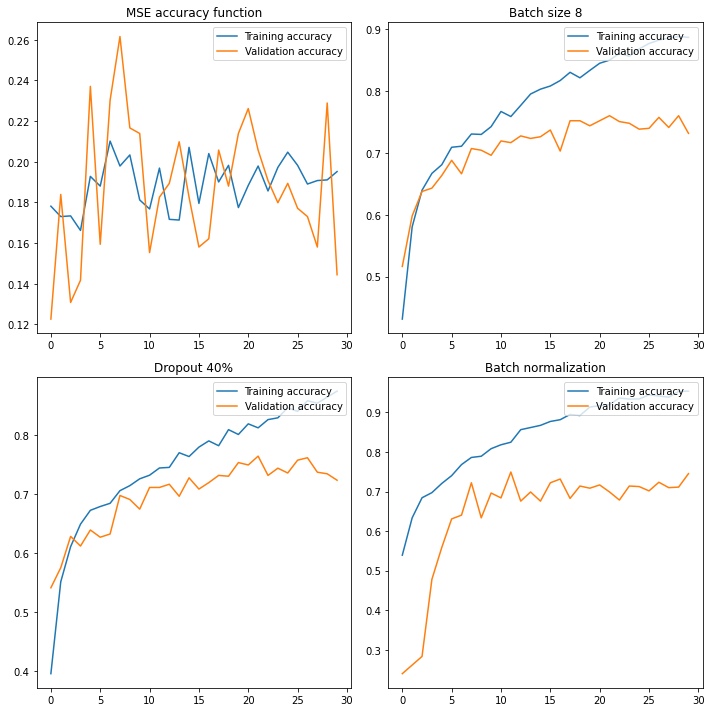

In [86]:
plt.rcParams["figure.figsize"] = (10,10)

accuracy_base = history_base.history['accuracy']
val_accuracy_base = history_base.history['val_accuracy']

accuracy_mse = history_msl.history['accuracy']
val_accuracy_mse = history_msl.history['val_accuracy']

accuracy_drop40 = history_drop40.history['accuracy']
val_accuracy_drop40 = history_drop40.history['val_accuracy']

accuracy_batch8 = history_batch8.history['accuracy']
val_accuracy_batch8 = history_batch8.history['val_accuracy']

accuracy_norm = history_norm.history['accuracy']
val_accuracy_norm = history_norm.history['val_accuracy']

plt.figure(figsize=(26.5, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy_base, label='Training accuracy')
plt.plot(epochs_range, val_accuracy_base, label='Validation accuracy')
plt.legend(loc='upper right')
plt.title('Base Model')

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(epochs_range, accuracy_mse, label='Training accuracy')
axs[0, 0].plot(epochs_range, val_accuracy_mse, label='Validation accuracy')
axs[0, 0].set_title("MSE accuracy function")
axs[0, 0].legend(loc='upper right')
axs[1, 0].plot(epochs_range, accuracy_drop40, label='Training accuracy')
axs[1, 0].plot(epochs_range, val_accuracy_drop40, label='Validation accuracy')
axs[1, 0].set_title("Dropout 40%")
axs[1, 0].legend(loc='upper right')
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].plot(epochs_range, accuracy_batch8, label='Training accuracy')
axs[0, 1].plot(epochs_range, val_accuracy_batch8, label='Validation accuracy')
axs[0, 1].set_title("Batch size 8")
axs[0, 1].legend(loc='upper right')
axs[1, 1].plot(epochs_range, accuracy_norm, label='Training accuracy')
axs[1, 1].plot(epochs_range, val_accuracy_norm, label='Validation accuracy')
axs[1, 1].set_title("Batch normalization")
axs[1, 1].legend(loc='upper right')
fig.tight_layout()

## Loss

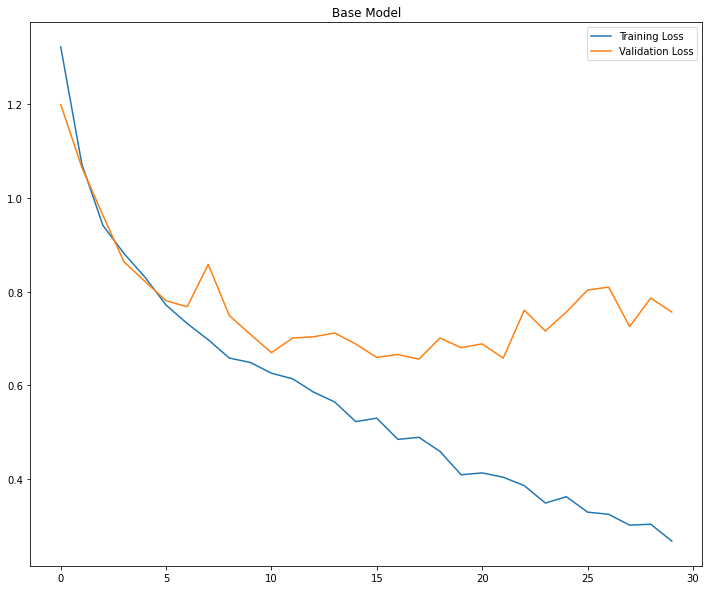

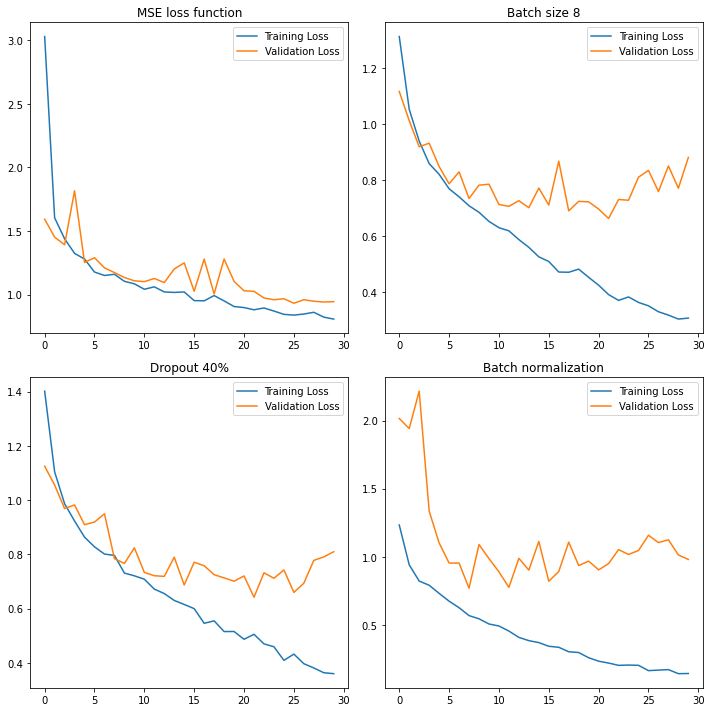

In [85]:
plt.rcParams["figure.figsize"] = (10,10)

loss_base = history_base.history['loss']
val_loss_base = history_base.history['val_loss']

loss_mse = history_msl.history['loss']
val_loss_mse = history_msl.history['val_loss']

loss_drop40 = history_drop40.history['loss']
val_loss_drop40 = history_drop40.history['val_loss']

loss_batch8 = history_batch8.history['loss']
val_loss_batch8 = history_batch8.history['val_loss']

loss_norm = history_norm.history['loss']
val_loss_norm = history_norm.history['val_loss']

plt.figure(figsize=(26.5, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_base, label='Training Loss')
plt.plot(epochs_range, val_loss_base, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Base Model')

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(epochs_range, loss_mse, label='Training Loss')
axs[0, 0].plot(epochs_range, val_loss_mse, label='Validation Loss')
axs[0, 0].set_title("MSE loss function")
axs[0, 0].legend(loc='upper right')
axs[1, 0].plot(epochs_range, loss_drop40, label='Training Loss')
axs[1, 0].plot(epochs_range, val_loss_drop40, label='Validation Loss')
axs[1, 0].set_title("Dropout 40%")
axs[1, 0].legend(loc='upper right')
axs[1, 0].sharex(axs[0, 0])
axs[0, 1].plot(epochs_range, loss_batch8, label='Training Loss')
axs[0, 1].plot(epochs_range, val_loss_batch8, label='Validation Loss')
axs[0, 1].set_title("Batch size 8")
axs[0, 1].legend(loc='upper right')
axs[1, 1].plot(epochs_range, loss_norm, label='Training Loss')
axs[1, 1].plot(epochs_range, val_loss_norm, label='Validation Loss')
axs[1, 1].set_title("Batch normalization")
axs[1, 1].legend(loc='upper right')
fig.tight_layout()

# Conclusions
Above we are able to observe and compare the training and validation accuracy and loss scores of the original model to the adjustments made throughout the assignment. We increase the epochs to 30 from the original 15, to experiment further and see how this effected the results.
##### Base Model
From the base model - we can start to see signs of overfitting between the 5th and 10th epoch as the difference in accuracy between training and validation starts to increase. By the 30th epoch, training accuracy is around 90% while validation is at around 70% - clearly showing overfitting. By looking at the Loss Metrics, we can see that the validation loss being greater than the training loss as the epochs increase - showing signs of overfitting.
##### Mean Squared Error (MSE)
As we can observe from the visualizations above the model had a far worst performance when using the mean squared error as a loss function than the original model that used Cross Entropy instead in terms of accuracy. Both validation and training accuracy were below 20% by the last epoch. 

Cross Entropy measures the distance between the classification distribution in the data compared to that produced by the model. This method is seen as more reliable and precise than Mean Squared Error (MSE) specially for sigmoid and softmax outputs which are found classification tasks. However, the ReLu activation function is used instead for this multi-layered network. As the ReLu activation functions, like sigmoid, is a non linear activation function, as an hypothesis we can interpret the bad results due to the same reason.

However, by looking at the loss visualizations - we are able to observe less overfitting. While validation loss continues to be greater than training loss , the values are much closer to each other and both settle between 1 and 1.5. 
##### Batch size 8
Reducing the Batch size from 32 to 8 had very little effect on the training and validation accuracy and loss of the model. By the 30th epoch, both accuracy measures where similar to the original model and curves plotted on the graphs also follow similar trends. Therefore, this technique had no real effect on solving the overfitting issue - as the model behaved in the same way.
##### Dropout 40%
Changing the dropout rate to 40% also had little effect on the overfitting problem of the model. By looking at the graphs we are able to see that the curves follow a very similar trend to the original and overfitting is noticeble again from a similar position as it gradually increases as the epochs increase.
##### Batch Normalization
As expected, by adding batch normalization to our layered network, we are able to stabilize and make the network learn faster - thus seeing overfitting at actually an earlier stage. The distance from the validation and training accuracy curves is greater than the other models. We are able to see that the validation accuracy stabilizes at around 65%-70% from the 5th epoch onwards while the training accuracy continues to increase to almost 100%. The same applies for the loss visualization as distance between validation loss and training loss shows overfitting  at an earlier stage. 